In [496]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
import re
import pandas as pd
import matplotlib.pyplot as plt

class MetricsAnalysis:
    def __init__(self, file_path):
        self.file_path = file_path
        self.df = self.load_data()
    
    def load_data(self):
        df = pd.read_csv(self.file_path, index_col=0)
        df.fillna(0, inplace=True)  
        return df
    

    def visualize_data(self):
        df_cleaned = self.df.copy()
        def clean_column_name(column_name):
            return re.sub(r'^\d+\-', '', column_name) 
        df_cleaned.columns = [clean_column_name(col) for col in df_cleaned.columns]
        return df_cleaned


    def standalone_data(self):
        return self.df.loc[["q#", "qmod", "qasm"], :] 
            
    def hosted_data(self):
        return self.df.loc[["cirq", "qapl", "qiskit", "qrisp"], :] 
       
    def plot_metrics(self, data: dict, filter: str='all', palette="tab10"):
        df = self.df.copy()
        if filter == 'hosted':
            df = self.hosted_data()
        elif filter == 'standalone':
            df = self.standalone_data() 
        
        plt.figure(figsize=(10, 4))
        ax = df.T.plot(kind='bar', figsize=(10, 4), colormap=palette, title=data['title'])
        ax.legend(title="Implementaciones", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xlabel(data['xlabel'])
        plt.ylabel(data['ylabel'])
        plt.xticks(rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

    def compare_against(self, reference: str, palette="coolwarm"):
        if reference not in self.df.index:
            raise ValueError(f"{reference} data not found")        
        fig, ax = plt.subplots(figsize=(12, 6))
        df_compare = self.df.div(self.df.loc[reference])  
        df_compare.drop(index=reference, inplace=True)  
        for lang in df_compare.index:
            ax.plot(df_compare.columns, df_compare.loc[lang], marker='o', label=lang)        
        ax.axhline(1, color='gray', linestyle='--', alpha=0.7)
        ax.set_title(f"Normalized comparison: Quantum Programming Languages vs {reference}")
        ax.set_xlabel("Algorithms")
        ax.set_ylabel(f"Ratio respect to {reference}")
        ax.legend(title="Languages")
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    def compare_against2(self, reference: str, palette="coolwarm"):
        if reference not in self.df.index:
            raise ValueError(f"{reference} data not found.")        
        fig, ax = plt.subplots(figsize=(12, 6))
        df_compare = self.df.div(self.df.loc[reference]) 
        df_compare.drop(index=reference, inplace=True)          
        for lang in df_compare.index:
            ax.plot(df_compare.columns, df_compare.loc[lang], marker='o', label=lang)        
        ax.axhline(1, color='gray', linestyle='--', alpha=0.7)
        ax.set_title(f"Normalized comparison: Quantum Programming Languages vs {reference}")
        ax.set_xlabel("Algorithms")
        ax.set_ylabel(f"Ratio respect to {reference}")
        ax.legend(title="Languages")
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    def compare_averages(self, metric: str, palette="coolwarm"):
        df_avg = self.df.mean(axis=1) 
        df_avg = df_avg.sort_values()
        fig, ax = plt.subplots(figsize=(12, 6))
        df_avg.plot(kind="bar", colormap=palette, ax=ax)
        ax.set_title(f"Average {metric} Across Quantum Programming Languages")
        ax.set_xlabel("Quantum Programming Languages")
        ax.set_ylabel(f"Average {metric}")
        ax.grid(axis="y", linestyle="--", alpha=0.7)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    def plot_loc_vs_cc(self, df_cc):
        """
        Plots LOC vs Cyclomatic Complexity in a scatter plot for all quantum programming languages.        
        :param df_cc: DataFrame containing the Cyclomatic Complexity (CC) data.
        """
        df_avg_loc = self.df.mean(axis=1)  # Promedio de LOC por lenguaje
        df_avg_cc = df_cc.mean(axis=1)  # Promedio de CC por lenguaje

        fig, ax = plt.subplots(figsize=(10, 6))

        for lang, loc, cc in zip(df_avg_loc.index, df_avg_loc, df_avg_cc):
            ax.scatter(loc, cc, label=lang, s=100)
            ax.text(loc, cc, lang, fontsize=10, ha='right', va='bottom')

        ax.set_title("LOC vs Cyclomatic Complexity in Quantum Programming Languages")
        ax.set_xlabel("Average Lines of Code (LOC)")
        ax.set_ylabel("Average Cyclomatic Complexity (CC)")
        ax.grid(True, linestyle='--', alpha=0.7)
        plt.legend(title="Languages")
        plt.tight_layout()
        plt.show()


    
    def plot_loc_cc_bars(self, df_cc):
        """
        Compares LOC vs Cyclomatic Complexity in a bar chart for all quantum programming languages.
        
        :param df_cc: DataFrame containing the Cyclomatic Complexity (CC) data.
        """
        df_avg_loc = self.df.mean(axis=1)  # Average LOC per language
        df_avg_cc = df_cc.mean(axis=1)  # Average CC per language

        # Crear un DataFrame de comparación
        df_comparison = pd.DataFrame({'LOC': df_avg_loc, 'CC': df_avg_cc})

        # Graficar el DataFrame
        df_comparison.plot(kind='bar', figsize=(12, 6), colormap="viridis", width=0.7)

        plt.title("Comparison of LOC vs Cyclomatic Complexity in Quantum Programming Languages")
        plt.xlabel("Quantum Programming Languages")
        plt.ylabel("Metric Value")
        plt.xticks(rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.legend(title="Metrics")
        plt.tight_layout()
        plt.show()


    def plot_heatmap(self, df, metric):
        """
        Plots a heatmap to show the correlation between different quantum algorithms.

        :param df: DataFrame containing the metric data (either LOC or CC).
        :param metric: "LOC" or "CC".
        """
        plt.figure(figsize=(10, 6))
        sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
        plt.title(f"Correlation Heatmap of {metric} Between Quantum Algorithms")
        plt.show()


    def plot_radar_chart(self, df_loc, df_cc):
        """
        Plots a radar chart comparing LOC and CC for each quantum programming language.

        :param df_loc: DataFrame containing LOC data.
        :param df_cc: DataFrame containing CC data.
        """
        categories = df_loc.index.tolist()
        values_loc = df_loc.mean(axis=1).tolist()
        values_cc = df_cc.mean(axis=1).tolist()

        angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()

        values_loc += values_loc[:1]  # Cerrar el gráfico
        values_cc += values_cc[:1]
        angles += angles[:1]

        fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

        ax.fill(angles, values_loc, color="blue", alpha=0.3, label="LOC")
        ax.fill(angles, values_cc, color="red", alpha=0.3, label="CC")

        ax.set_yticklabels([])
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(categories, fontsize=10)

        plt.title("Comparison of LOC and CC Across Quantum Programming Languages", size=12)
        plt.legend(loc="upper right")
        plt.show()

    


<Figure size 1000x400 with 0 Axes>

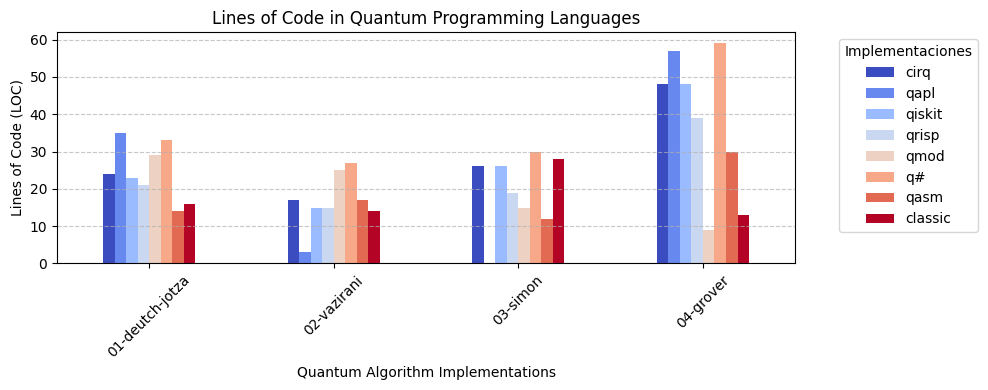

In [498]:
analysis = MetricsAnalysis("results/loc.csv")

analysis.plot_metrics({
    'title': 'Lines of Code in Quantum Programming Languages',
    'xlabel': 'Quantum Algorithm Implementations',
    'ylabel': 'Lines of Code (LOC)',
    'kind': 'bar'
}, filter='all')


<Figure size 1000x400 with 0 Axes>

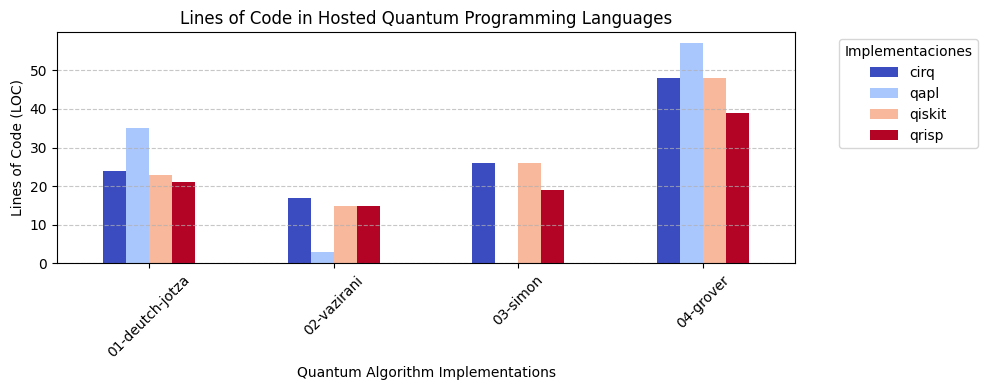

In [499]:
analysis.plot_metrics({
    'title': 'Lines of Code in Hosted Quantum Programming Languages',
    'xlabel': 'Quantum Algorithm Implementations',
    'ylabel': 'Lines of Code (LOC)',
    'kind': 'bar'
}, filter='hosted')


<Figure size 1000x400 with 0 Axes>

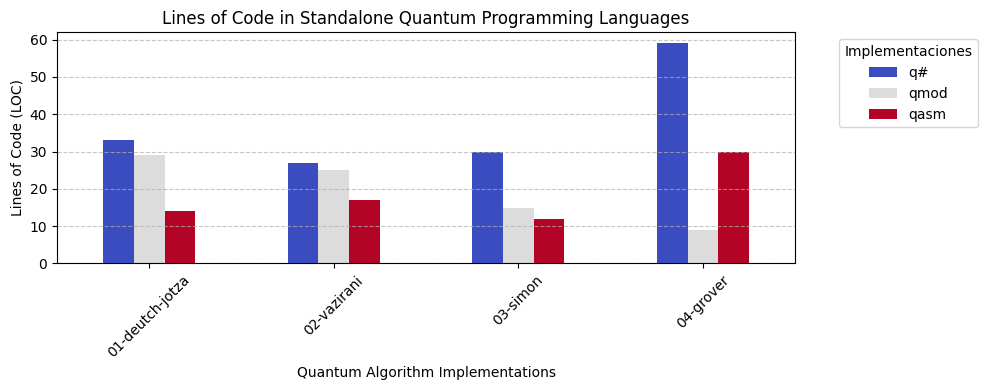

In [500]:
analysis.plot_metrics({
    'title': 'Lines of Code in Standalone Quantum Programming Languages',
    'xlabel': 'Quantum Algorithm Implementations',
    'ylabel': 'Lines of Code (LOC)',
    'kind': 'bar'
}, filter='standalone')

<Figure size 1000x400 with 0 Axes>

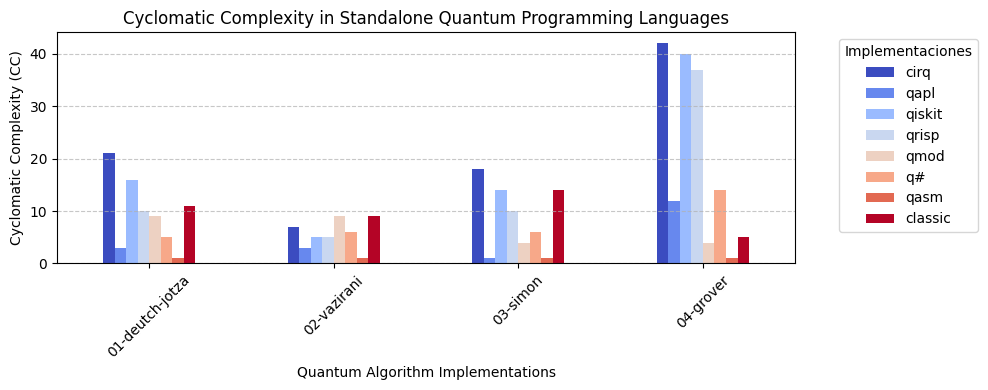

In [501]:
analysis = MetricsAnalysis("results/cyclomatic_complexity_calculator.csv")
analysis.plot_metrics({
    'title': 'Cyclomatic Complexity in Standalone Quantum Programming Languages',
    'xlabel': 'Quantum Algorithm Implementations',
    'ylabel': 'Cyclomatic Complexity (CC)',
    'kind': 'bar'
}, filter='all')

<Figure size 1000x400 with 0 Axes>

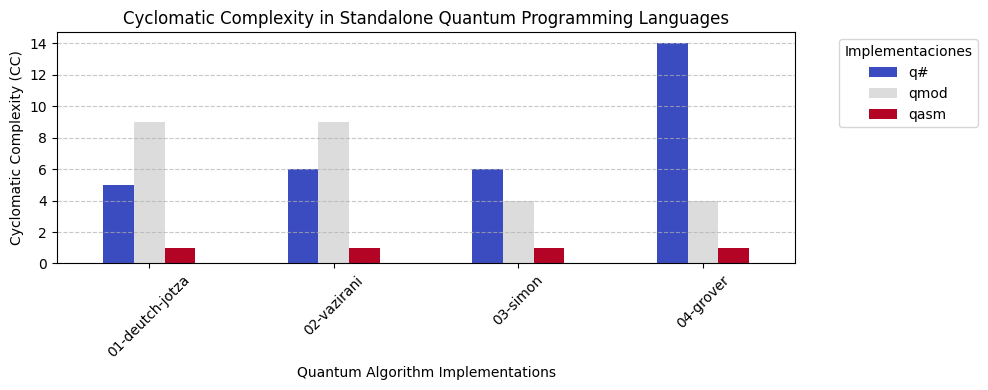

In [502]:
analysis = MetricsAnalysis("results/cyclomatic_complexity_calculator.csv")
analysis.plot_metrics({
    'title': 'Cyclomatic Complexity in Standalone Quantum Programming Languages',
    'xlabel': 'Quantum Algorithm Implementations',
    'ylabel': 'Cyclomatic Complexity (CC)',
    'kind': 'bar'
}, filter='standalone')


<Figure size 1000x400 with 0 Axes>

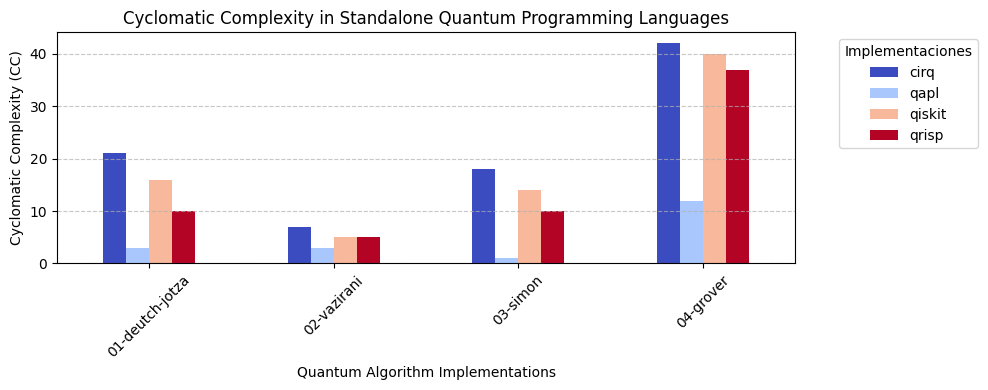

In [503]:
analysis = MetricsAnalysis("results/cyclomatic_complexity_calculator.csv")
analysis.plot_metrics({
    'title': 'Cyclomatic Complexity in Standalone Quantum Programming Languages',
    'xlabel': 'Quantum Algorithm Implementations',
    'ylabel': 'Cyclomatic Complexity (CC)',
    'kind': 'bar'
}, filter='hosted')

In [504]:
#analysis.compare_against2("qasm")

In [505]:
#analysis.compare_against("classic")

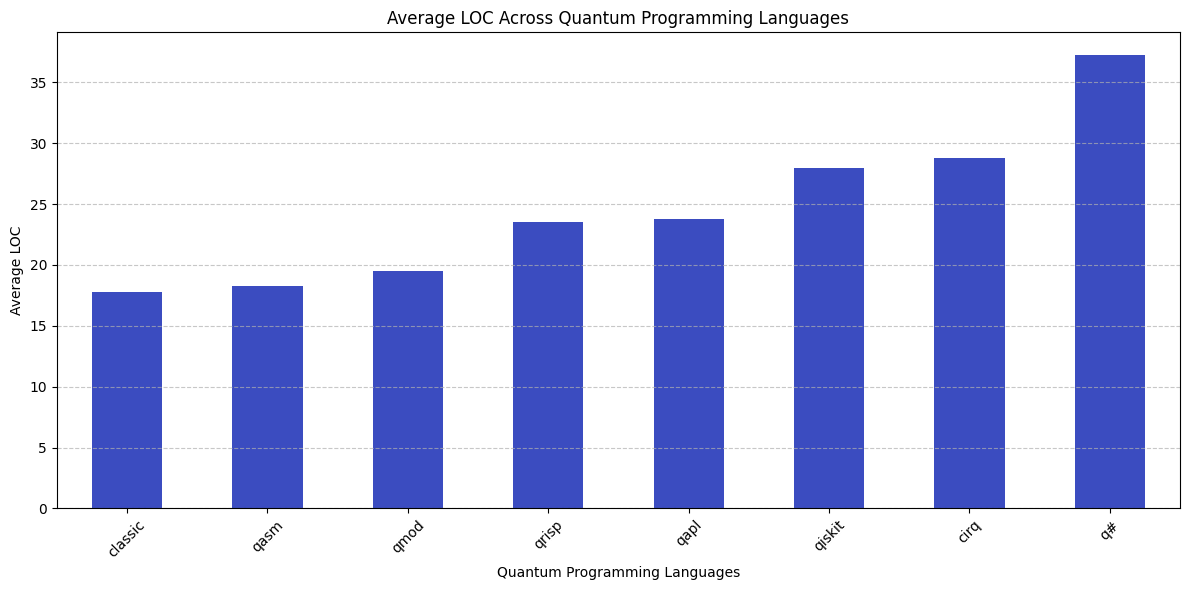

In [506]:
analysis = MetricsAnalysis("results/loc.csv")
analysis.compare_averages(metric="LOC")


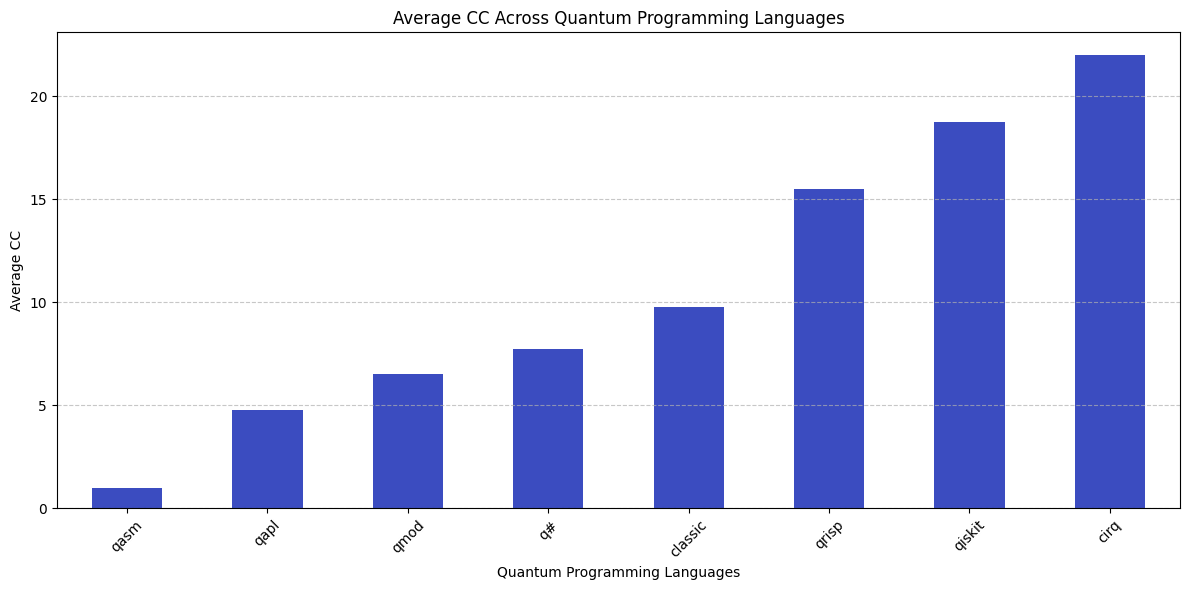

In [507]:
analysis = MetricsAnalysis("results/cyclomatic_complexity_calculator.csv")
analysis.compare_averages(metric="CC")

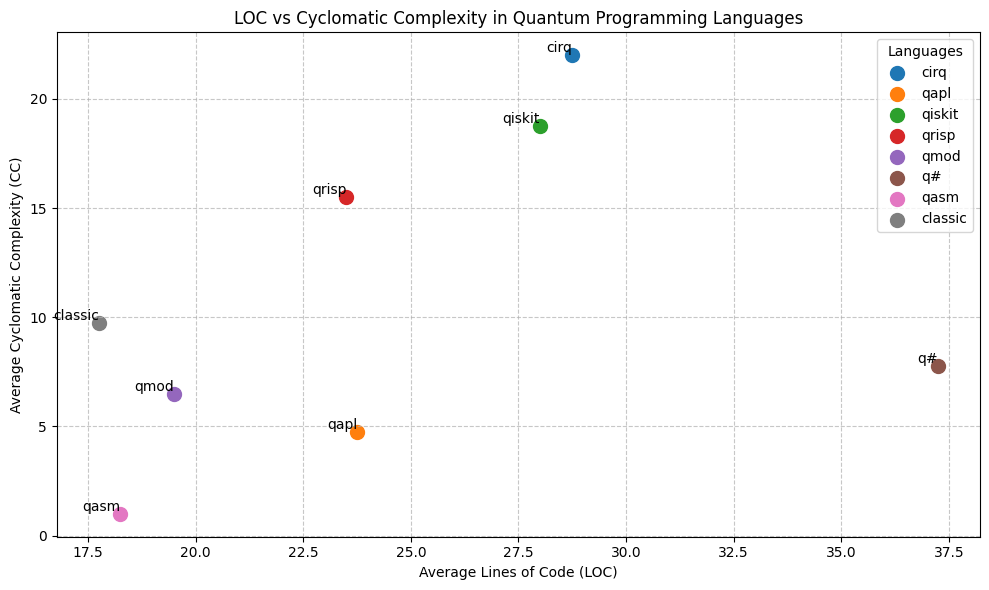

In [508]:
# Cargar los dos archivos CSV (LOC y CC)
df_loc = MetricsAnalysis("results/loc.csv")  # Carga LOC
df_cc = pd.read_csv("results/cyclomatic_complexity_calculator.csv", index_col=0)  # Carga CC

# Graficar LOC vs CC en un scatter plot
df_loc.plot_loc_vs_cc(df_cc)


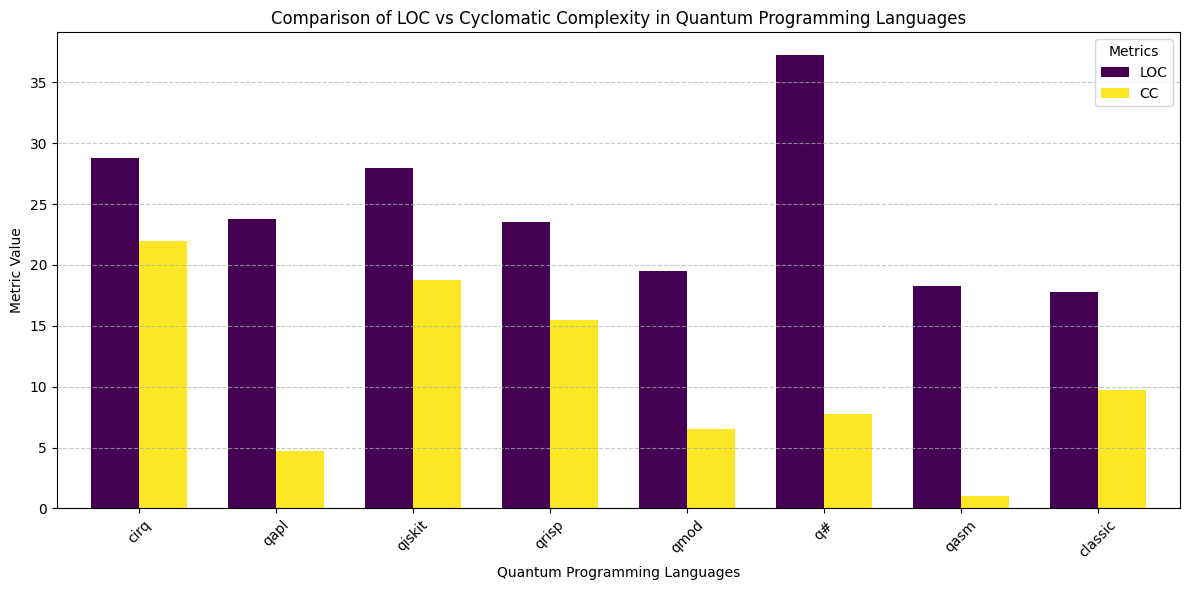

In [509]:
# Cargar los dos archivos CSV (LOC y CC)
df_loc = MetricsAnalysis("results/loc.csv")
df_cc = pd.read_csv("results/cyclomatic_complexity_calculator.csv", index_col=0)

# Graficar LOC vs CC en barras
df_loc.plot_loc_cc_bars(df_cc)


In [510]:
# Cargar los datos correctamente
df_loc = MetricsAnalysis("results/loc.csv")  # Instancia de la clase
df_cc = pd.read_csv("results/cyclomatic_complexity_calculator.csv", index_col=0)  # DataFrame CC

# Ahora pasamos los DataFrames correctos
#df_loc.plot_heatmap(df_loc.df, "LOC")  # ✅ Ahora pasamos el DataFrame de LOC
#df_loc.plot_heatmap(df_cc, "CC")  # ✅ Pasamos el DataFrame de CC


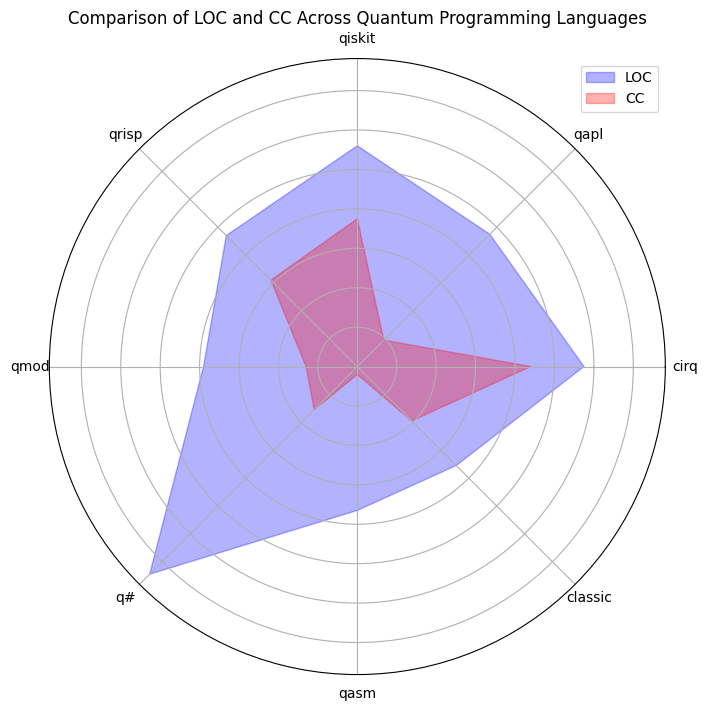

In [511]:
df_loc = MetricsAnalysis("results/loc.csv") 
df_cc = pd.read_csv("results/cyclomatic_complexity_calculator.csv", index_col=0)
df_loc.plot_radar_chart(df_loc.df, df_cc) 

In [512]:
df_loc = MetricsAnalysis("results/loc.csv") 
df_loc.visualize_data()

,deutch-jotza,vazirani,simon,grover
cirq,24,17,26,48
qapl,35,3,0,57
qiskit,23,15,26,48
qrisp,21,15,19,39
qmod,29,25,15,9
q#,33,27,30,59
qasm,14,17,12,30
classic,16,14,28,13


In [513]:
df_cyclomatic = MetricsAnalysis("results/cyclomatic_complexity_calculator.csv") 
df_cyclomatic.visualize_data()

,deutch-jotza,vazirani,simon,grover
cirq,21,7,18,42
qapl,3,3,1,12
qiskit,16,5,14,40
qrisp,10,5,10,37
qmod,9,9,4,4
q#,5,6,6,14
qasm,1,1,1,1
classic,11,9,14,5
